In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from pyHalo.preset_models import CDM
from pyHalo import plotting_routines
from copy import deepcopy
from lenstronomy.Util.correlation import power_spectrum_1d
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from galsim import InterpolatedImage, Image

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):  # ../../
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

import mejiro
from mejiro.lenses.test import SampleStrongLens
from mejiro.lenses import lens_util
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import ft
from mejiro.utils import util
from mejiro.helpers import gs, survey_sim, psf

In [2]:
# script configuration options
debugging = False
require_alignment = True
limit = 100
snr_threshold = 50
einstein_radius_threshold = 0.
log_m_host_threshold = 13.5

# set subhalo and imaging params
subhalo_params = {
    'r_tidal': 0.5,
    'sigma_sub': 0.055,  
    'los_normalization': 0.
}
oversample = 5
num_pix = 45
side = 4.95
bands = ['F106', 'F129', 'F158', 'F184']

control_band = 'F129'
position_control = {
    '1': (2048, 2048),
}
positions = {
    '4': (4, 4092),
    '2': (2048, 2048),
    '5': (2048, 2048)
    # '9': (4, 4),
    # '17': (4092, 4092)
}

In [3]:
# set output dir
save_dir = os.path.join(array_dir, 'power_spectra_dev')
util.create_directory_if_not_exists(save_dir)
util.clear_directory(save_dir)

# debugging? set pipeline dir accordingly
pipeline_params = util.hydra_to_dict(config.pipeline)
if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

# collect lenses
print(f'Collecting lenses...')
lens_list = survey_sim.collect_all_detectable_lenses(os.path.join(pipeline_dir, '01'))
print(f'Collected {len(lens_list)} candidate lens(es).')
lenses_to_process = []
num_lenses = 0
for lens in lens_list:
    if lens.snr > snr_threshold and lens.get_einstein_radius() > einstein_radius_threshold and np.log10(
            lens.main_halo_mass) > log_m_host_threshold:
        lenses_to_process.append(lens)
        num_lenses += 1
    if limit is not None and num_lenses >= limit:
        break
print(f'Collected {len(lenses_to_process)} lens(es).')

# read cached PSFs
cached_psfs = {}
psf_cache_dir = os.path.join(config.machine.data_dir, 'cached_psfs')
psf_id_strings = []
for band in bands:
    for detector, detector_position in {**position_control, **positions}.items():
        psf_id_strings.append(
            psf.get_psf_id_string(band, detector, detector_position, oversample))

for id_string in psf_id_strings:
    cached_psfs[id_string] = psf.load_cached_psf(id_string, psf_cache_dir)

Collected 10074 candidate lens(es).
Collected 9 lens(es).
Loading cached PSF: /data/bwedig/mejiro/cached_psfs/F106_1_2048_2048_5.pkl
Loading cached PSF: /data/bwedig/mejiro/cached_psfs/F106_4_4_4092_5.pkl
Loading cached PSF: /data/bwedig/mejiro/cached_psfs/F106_2_2048_2048_5.pkl
Loading cached PSF: /data/bwedig/mejiro/cached_psfs/F106_5_2048_2048_5.pkl
Loading cached PSF: /data/bwedig/mejiro/cached_psfs/F129_1_2048_2048_5.pkl
Loading cached PSF: /data/bwedig/mejiro/cached_psfs/F129_4_4_4092_5.pkl
Loading cached PSF: /data/bwedig/mejiro/cached_psfs/F129_2_2048_2048_5.pkl
Loading cached PSF: /data/bwedig/mejiro/cached_psfs/F129_5_2048_2048_5.pkl
Loading cached PSF: /data/bwedig/mejiro/cached_psfs/F158_1_2048_2048_5.pkl
Loading cached PSF: /data/bwedig/mejiro/cached_psfs/F158_4_4_4092_5.pkl
Loading cached PSF: /data/bwedig/mejiro/cached_psfs/F158_2_2048_2048_5.pkl
Loading cached PSF: /data/bwedig/mejiro/cached_psfs/F158_5_2048_2048_5.pkl
Loading cached PSF: /data/bwedig/mejiro/cached_psfs

In [4]:
for i, lens in enumerate(lenses_to_process):
    print(f'{i}: StrongLens {lens.uid}, {np.log10(lens.main_halo_mass):.2f}, {lens.snr:.2f}')

0: StrongLens 00002123, 13.56, 55.85
1: StrongLens 00002351, 13.51, 52.34
2: StrongLens 00002871, 13.73, 50.13
3: StrongLens 00003282, 13.57, 56.77
4: StrongLens 00006880, 13.56, 50.46
5: StrongLens 00007009, 13.70, 56.57
6: StrongLens 00007143, 13.53, 83.87
7: StrongLens 00008554, 13.61, 61.10
8: StrongLens 00009949, 13.52, 83.04


In [5]:
lens = lenses_to_process[8]  # 7
print(f'Processing StrongLens {lens.uid}...')

lens._set_classes()

Processing StrongLens 00009949...


In [6]:
def get_large(lens, subhalo_params):
    return CDM(round(lens.z_lens, 2),
                round(lens.z_source, 2),
                sigma_sub=subhalo_params['sigma_sub'],
                log_mlow=9.5,
                log_mhigh=11.,
                log_m_host=np.log10(lens.main_halo_mass),
                r_tidal=subhalo_params['r_tidal'],
                cone_opening_angle_arcsec=lens.get_einstein_radius() * 3,
                LOS_normalization=subhalo_params['los_normalization'])

def get_med(lens, subhalo_params):
    return CDM(round(lens.z_lens, 2),
                round(lens.z_source, 2),
                sigma_sub=subhalo_params['sigma_sub'],
                log_mlow=8.,
                log_mhigh=9.5,
                log_m_host=np.log10(lens.main_halo_mass),
                r_tidal=subhalo_params['r_tidal'],
                cone_opening_angle_arcsec=lens.get_einstein_radius() * 3,
                LOS_normalization=subhalo_params['los_normalization'])

def get_small(lens, subhalo_params):
    return CDM(round(lens.z_lens, 2),
                round(lens.z_source, 2),
                sigma_sub=subhalo_params['sigma_sub'],
                log_mlow=6.,
                log_mhigh=8.,
                log_m_host=np.log10(lens.main_halo_mass),
                r_tidal=subhalo_params['r_tidal'],
                cone_opening_angle_arcsec=lens.get_einstein_radius() * 6,
                LOS_normalization=subhalo_params['los_normalization'])

In [7]:
if require_alignment:
    aligned = False
    i = 0
    while not aligned:
        large = get_large(lens, subhalo_params)
        aligned = lens_util.check_halo_image_alignment(lens, large, halo_mass=5e9)
        i += 1
    print(f'Aligned in {i} iteration(s).')
else:
    large = get_large(lens, subhalo_params)
print(f'{len(large.halos)} subhalo(es) in large subhalo population.')

Aligned in 36 iteration(s).
1 subhalo(es) in large subhalo population.


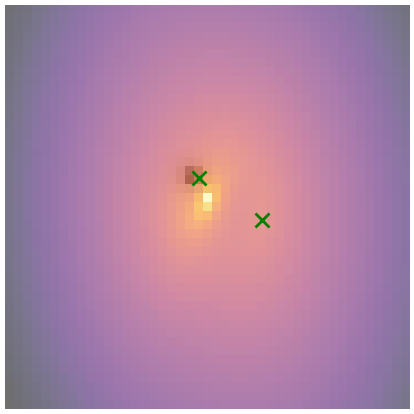

In [8]:
subhalo_lens = deepcopy(lens)
subhalo_lens.add_subhalos(large)
subhalo_kappa = subhalo_lens.get_subhalo_kappa(num_pix, side)
array = subhalo_lens.get_array(num_pix, side, control_band)
image_x, image_y = subhalo_lens.get_image_positions()

plt.imshow(np.log10(array), alpha=0.75, cmap='inferno')
plt.imshow(subhalo_kappa, alpha=0.25, cmap='binary')
plt.plot(image_x, image_y, 'gx', ms=10, markeredgewidth=2)
plt.axis('off')
plt.show()

In [9]:
if require_alignment:
    aligned = False
    i = 0
    while not aligned:
        med = get_med(lens, subhalo_params)
        aligned = lens_util.check_halo_image_alignment(lens, med, halo_mass=5e8)
        i += 1
    print(f'Aligned in {i} iteration(s).')
else:
    med = get_med(lens, subhalo_params)
print(f'{len(med.halos)} subhalo(es) in medium subhalo population.')

Aligned in 10 iteration(s).
22 subhalo(es) in medium subhalo population.


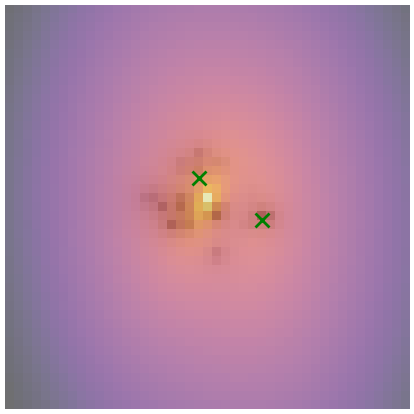

In [10]:
subhalo_lens = deepcopy(lens)
subhalo_lens.add_subhalos(med)
subhalo_kappa = subhalo_lens.get_subhalo_kappa(num_pix, side)
array = subhalo_lens.get_array(num_pix, side, control_band)
image_x, image_y = subhalo_lens.get_image_positions()

plt.imshow(np.log10(array), alpha=0.75, cmap='inferno')
plt.imshow(subhalo_kappa, alpha=0.25, cmap='binary')
plt.plot(image_x, image_y, 'gx', ms=10, markeredgewidth=2)
plt.axis('off')
plt.show()

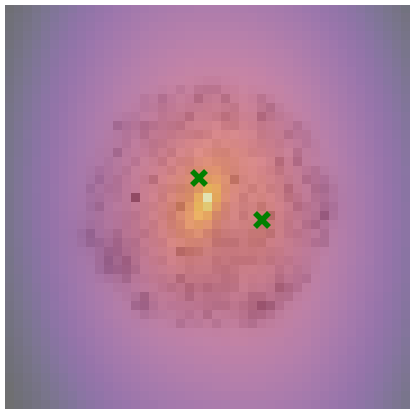

In [11]:
small = get_small(lens, subhalo_params)

subhalo_lens = deepcopy(lens)
subhalo_lens.add_subhalos(small)
subhalo_kappa = subhalo_lens.get_subhalo_kappa(num_pix, side)
array = subhalo_lens.get_array(num_pix, side, control_band)
image_x, image_y = subhalo_lens.get_image_positions()

plt.imshow(np.log10(array), alpha=0.75, cmap='inferno')
plt.imshow(subhalo_kappa, alpha=0.25, cmap='binary')
plt.plot(image_x, image_y, 'gx', ms=10, markeredgewidth=4)
plt.axis('off')
plt.show()

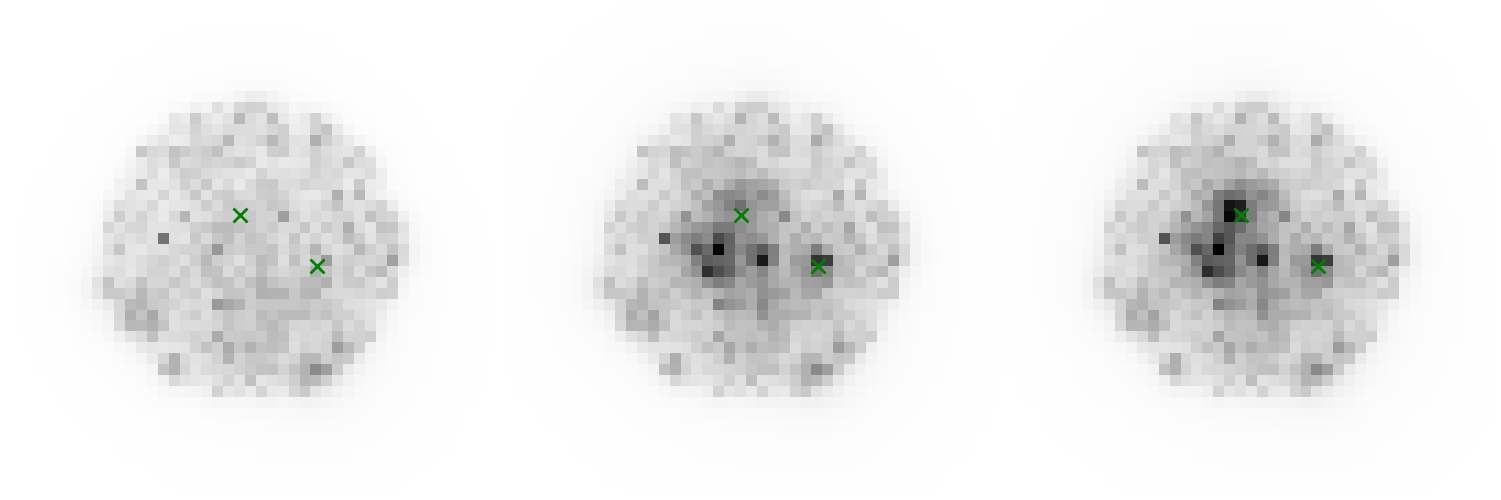

In [12]:
wdm = deepcopy(small)
mdm = wdm.join(med)
cdm = mdm.join(large)

wdm_lens = deepcopy(lens)
mdm_lens = deepcopy(lens)
cdm_lens = deepcopy(lens)

wdm_lens.add_subhalos(wdm)
mdm_lens.add_subhalos(mdm)
cdm_lens.add_subhalos(cdm)

wdm_kappa = wdm_lens.get_subhalo_kappa(num_pix, side)
mdm_kappa = mdm_lens.get_subhalo_kappa(num_pix, side)
cdm_kappa = cdm_lens.get_subhalo_kappa(num_pix, side)

vmin = 0
vmax = np.max([wdm_kappa, mdm_kappa, cdm_kappa])

_, ax = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
ax[0].imshow(wdm_kappa, cmap='binary', vmin=vmin, vmax=vmax)
ax[1].imshow(mdm_kappa, cmap='binary', vmin=vmin, vmax=vmax)
ax[2].imshow(cdm_kappa, cmap='binary', vmin=vmin, vmax=vmax)
for a in ax:
    a.axis('off')
    a.plot(image_x, image_y, 'gx', ms=10, markeredgewidth=2)
plt.show()

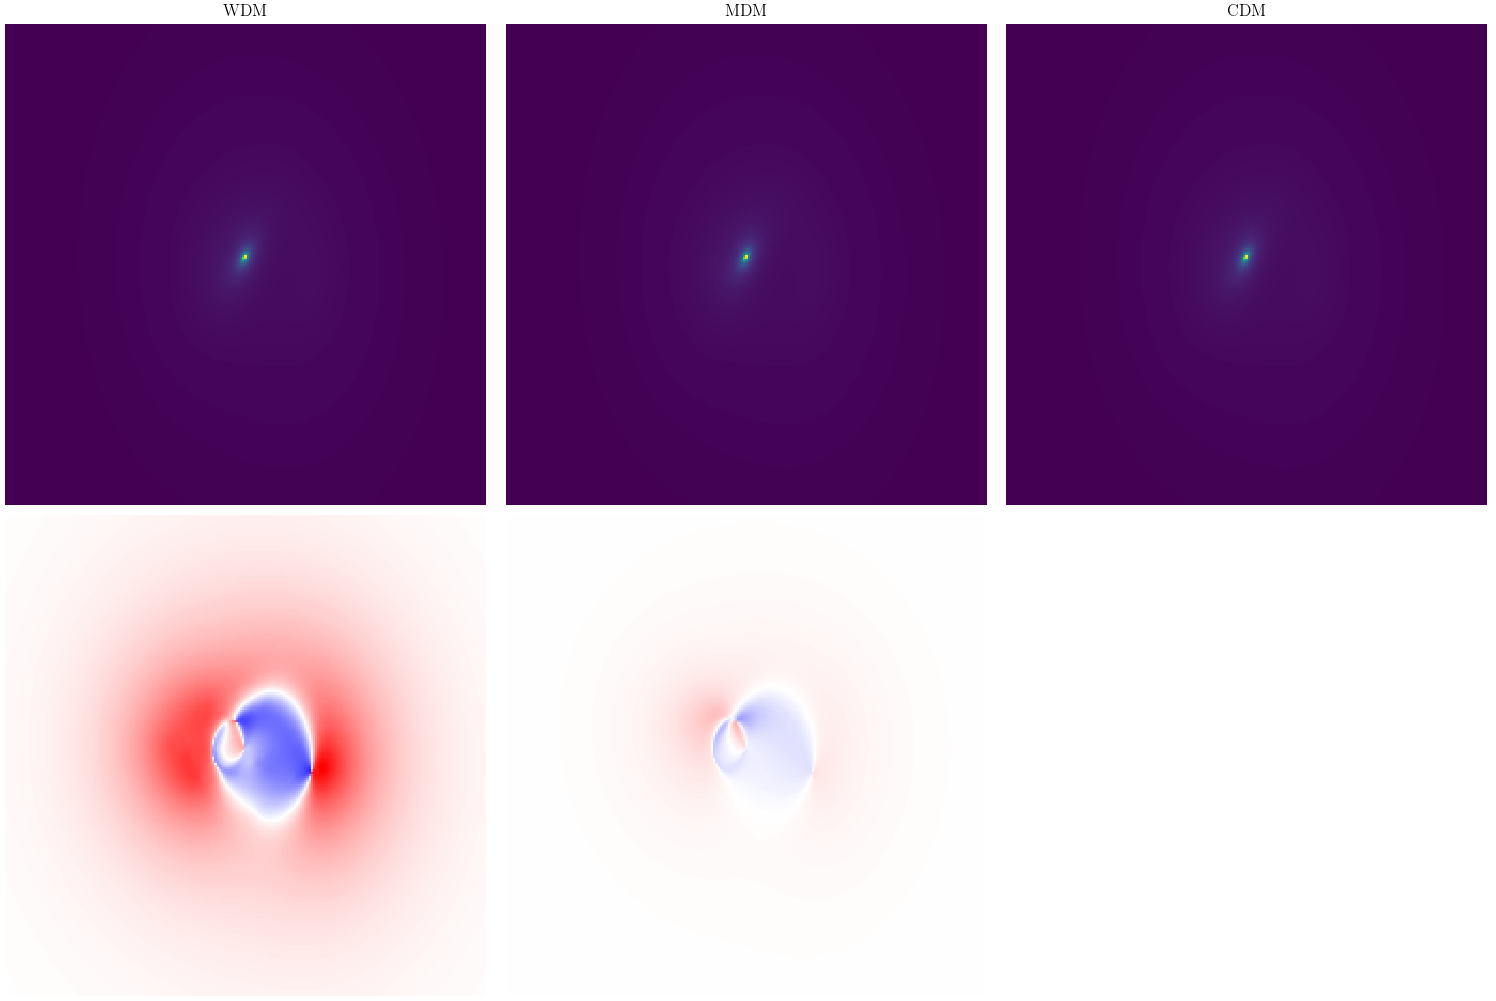

In [13]:
wdm_array = wdm_lens.get_array(num_pix * oversample, side, control_band)
mdm_array = mdm_lens.get_array(num_pix * oversample, side, control_band)
cdm_array = cdm_lens.get_array(num_pix * oversample, side, control_band)

wdm_residual = cdm_array - wdm_array
mdm_residual = cdm_array - mdm_array
min = np.min([wdm_residual, mdm_residual])
max = np.max([wdm_residual, mdm_residual])
vmax = np.max([np.abs(min), np.abs(max)])

_, ax = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)
ax[0, 0].imshow(wdm_array)
ax[0, 1].imshow(mdm_array)
ax[0, 2].imshow(cdm_array)
ax[1, 0].imshow(wdm_residual, cmap='bwr', vmin=-vmax, vmax=vmax)
ax[1, 1].imshow(mdm_residual, cmap='bwr', vmin=-vmax, vmax=vmax)
ax[0, 0].set_title('WDM')
ax[0, 1].set_title('MDM')
ax[0, 2].set_title('CDM')
for a in ax.flatten():
    a.axis('off')
plt.show()

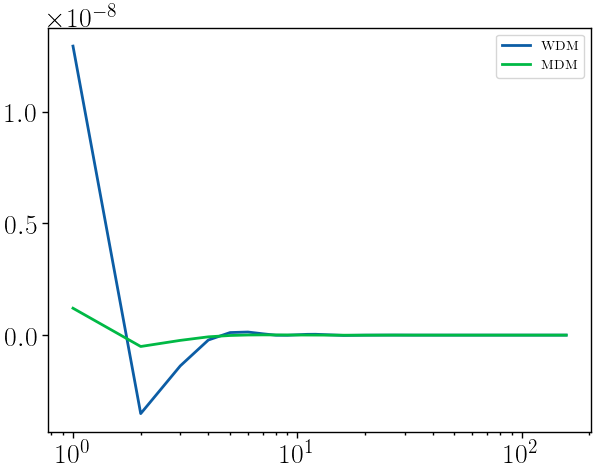

In [14]:
wdm_ps, r = power_spectrum_1d(wdm_array)
mdm_ps, _ = power_spectrum_1d(mdm_array)
cdm_ps, _ = power_spectrum_1d(cdm_array)

plt.plot(r, cdm_ps - wdm_ps, label='WDM')
plt.plot(r, cdm_ps - mdm_ps, label='MDM')
plt.xscale('log')
plt.legend()
plt.show()

In [15]:
def get_masked_exposure(lens, model, band, psf_kernel, num_pix, oversample):
    total_flux_cps = lens.get_total_flux_cps(band)
    interp = InterpolatedImage(Image(model, xmin=0, ymin=0), scale=0.11 / oversample, flux=total_flux_cps * 146)
    image = gs.convolve(interp, psf_kernel, num_pix)
    final_array = image.array

    mask = np.ma.getmask(lens.masked_snr_array)
    if mask.shape != final_array.shape:
        mask = util.center_crop_image(mask, final_array.shape)
    masked_image = np.ma.masked_array(final_array, mask)
    np.ma.set_fill_value(masked_image, 0)
    return masked_image.filled()

In [16]:
subhalos_psf_id_string = psf.get_psf_id_string(band=control_band, detector=1, detector_position=(2048, 2048), oversample=oversample)
subhalos_psf_kernel = cached_psfs[subhalos_psf_id_string]

wdm_exposure = get_masked_exposure(wdm_lens, wdm_array, control_band, subhalos_psf_kernel, num_pix, oversample)
mdm_exposure = get_masked_exposure(mdm_lens, mdm_array, control_band, subhalos_psf_kernel, num_pix, oversample)
cdm_exposure = get_masked_exposure(cdm_lens, cdm_array, control_band, subhalos_psf_kernel, num_pix, oversample)

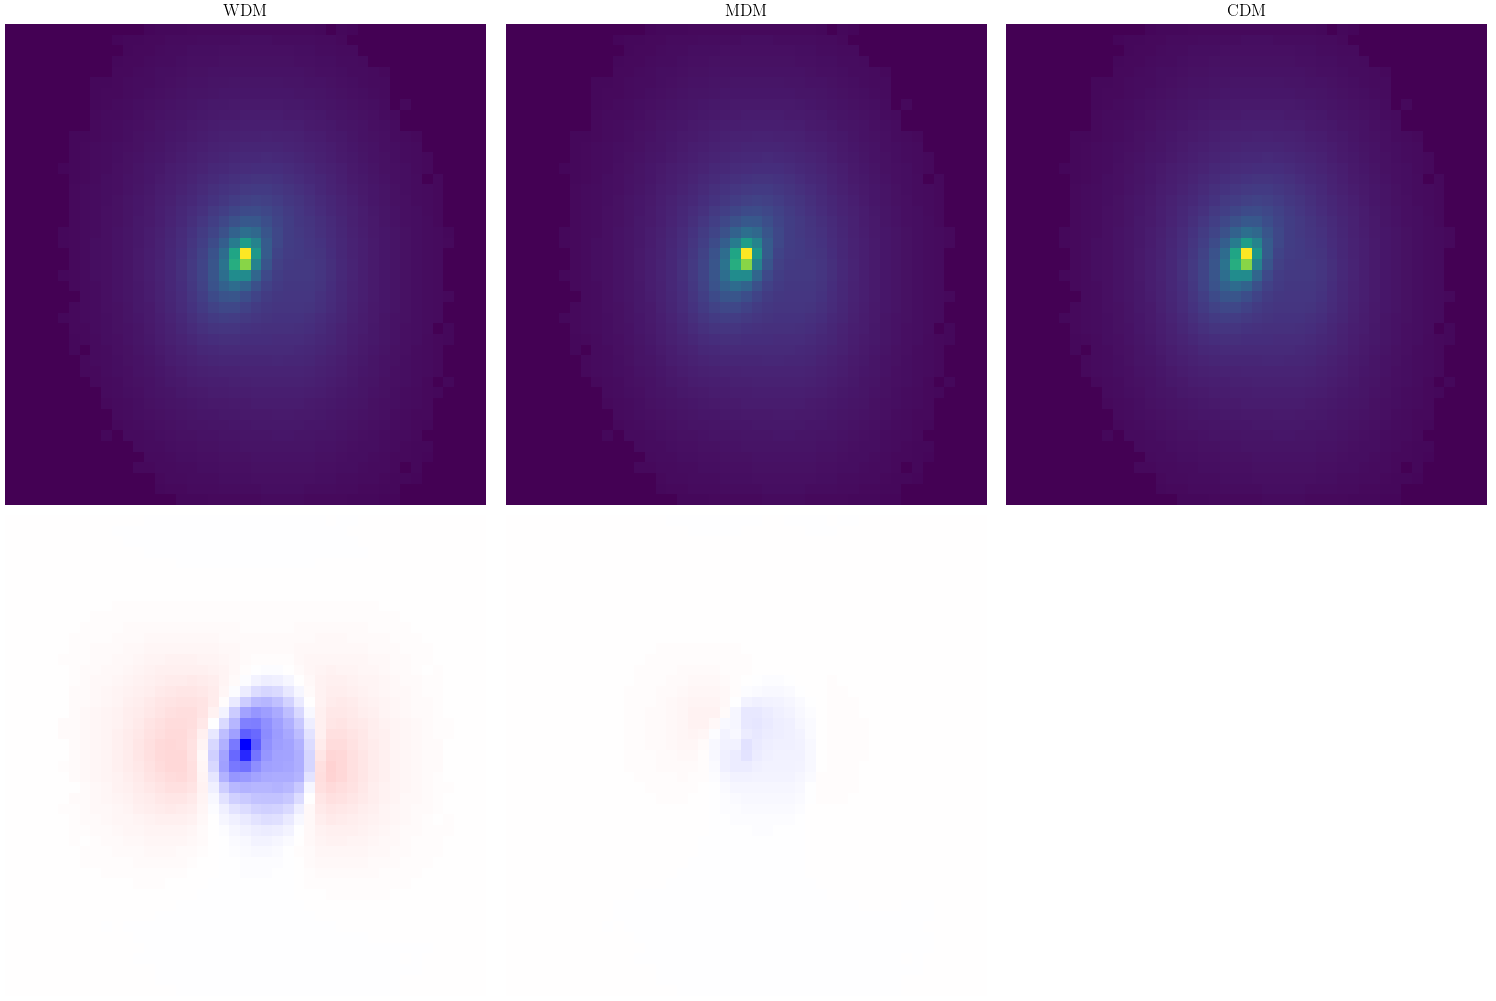

In [17]:
wdm_residual = cdm_exposure - wdm_exposure
mdm_residual = cdm_exposure - mdm_exposure
min = np.min([wdm_residual, mdm_residual])
max = np.max([wdm_residual, mdm_residual])
vmax = np.max([np.abs(min), np.abs(max)])

_, ax = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)
ax[0, 0].imshow(wdm_exposure)
ax[0, 1].imshow(mdm_exposure)
ax[0, 2].imshow(cdm_exposure)
ax[1, 0].imshow(wdm_residual, cmap='bwr', vmin=-vmax, vmax=vmax)
ax[1, 1].imshow(mdm_residual, cmap='bwr', vmin=-vmax, vmax=vmax)
ax[0, 0].set_title('WDM')
ax[0, 1].set_title('MDM')
ax[0, 2].set_title('CDM')
for a in ax.flatten():
    a.axis('off')
plt.show()

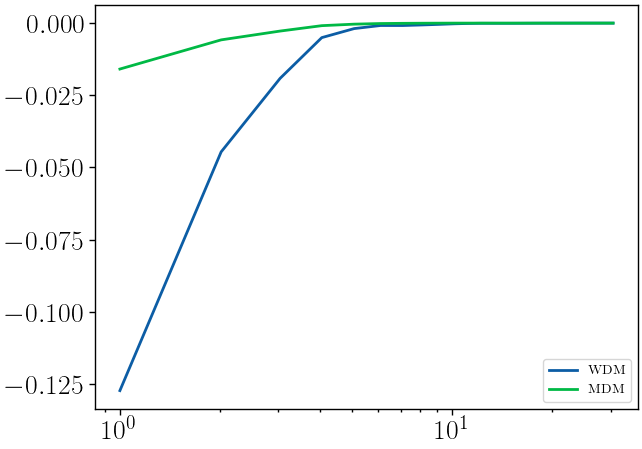

In [18]:
wdm_ps, r = power_spectrum_1d(wdm_exposure)
mdm_ps, _ = power_spectrum_1d(mdm_exposure)
cdm_ps, _ = power_spectrum_1d(cdm_exposure)

plt.plot(r, cdm_ps - wdm_ps, label='WDM')
plt.plot(r, cdm_ps - mdm_ps, label='MDM')
plt.xscale('log')
plt.legend()
plt.show()

In [19]:
position_exposures = []
for detector, detector_position in {**position_control, **positions}.items():
    exposure = get_masked_exposure(cdm_lens, cdm_array, control_band, cached_psfs[psf.get_psf_id_string(control_band, detector, detector_position, oversample)], num_pix, oversample)
    position_exposures.append(exposure)

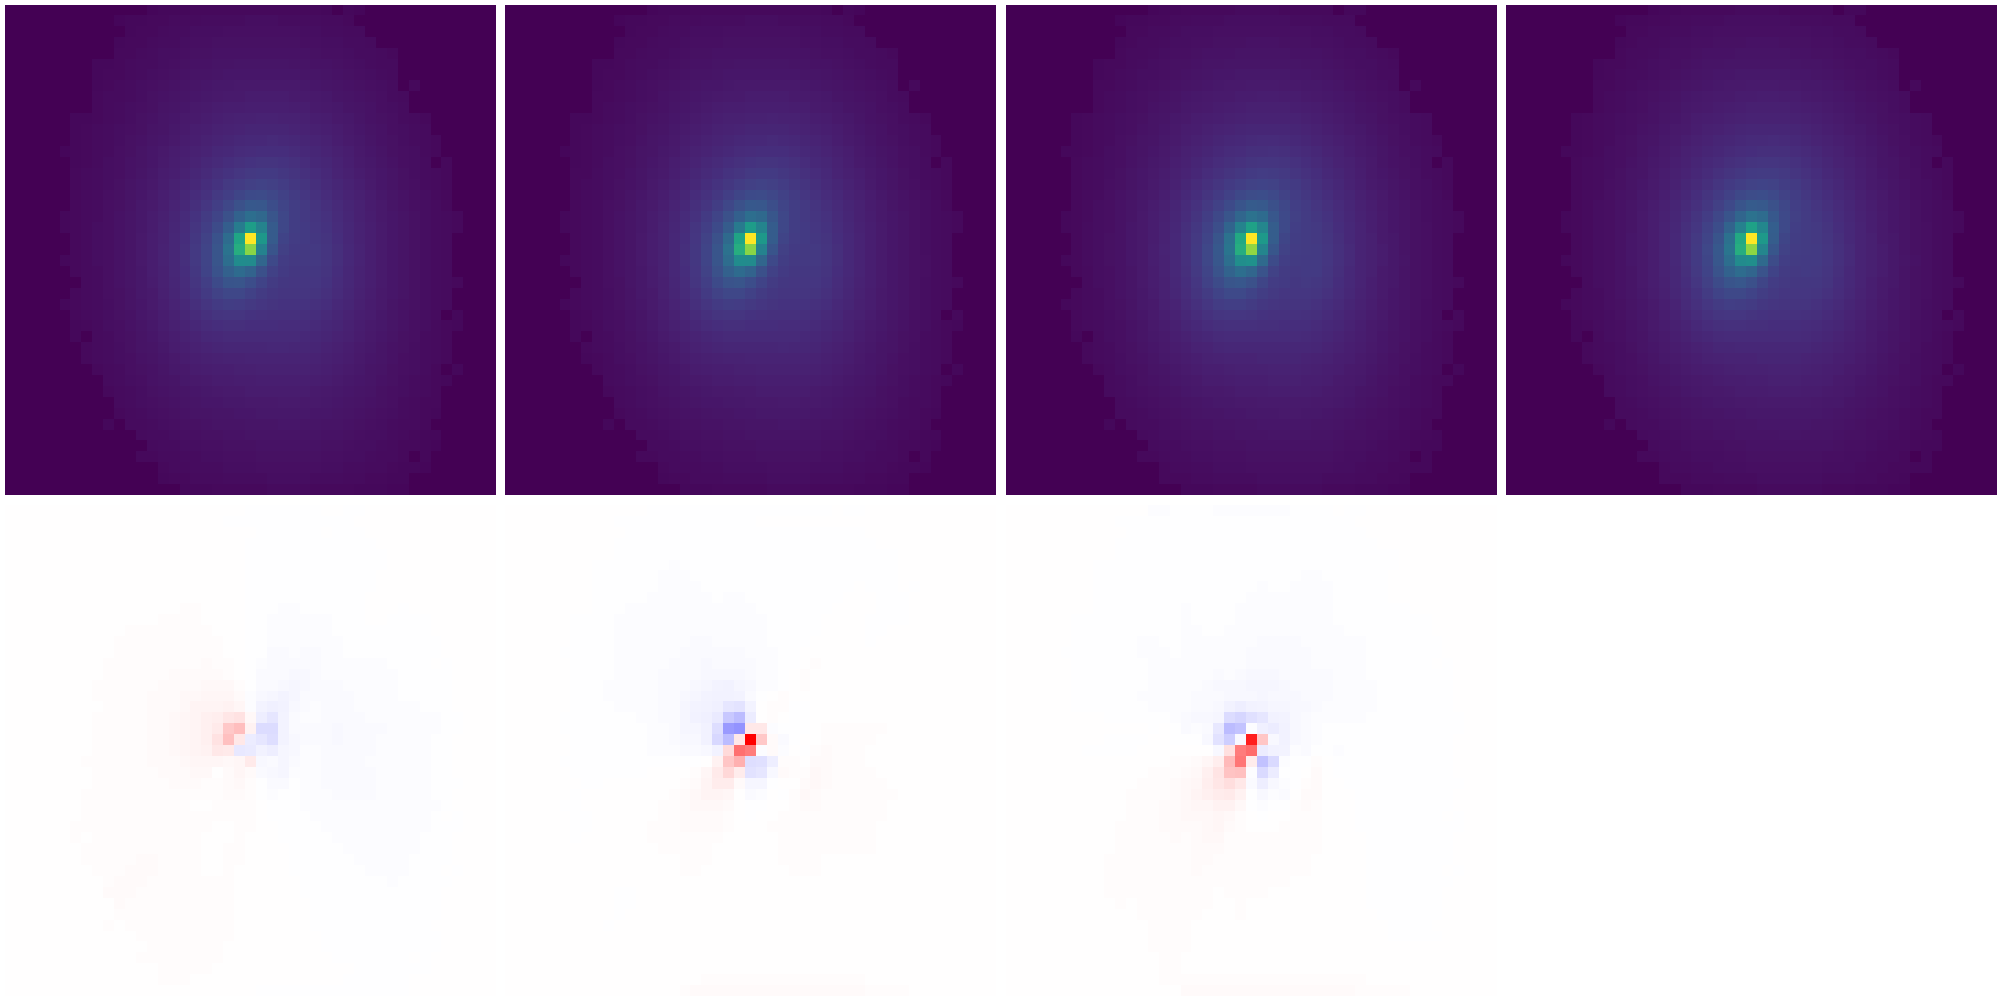

In [20]:
_, ax = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)

ax[0, 0].imshow(position_exposures[0])
ax[0, 1].imshow(position_exposures[1])
ax[0, 2].imshow(position_exposures[2])
ax[0, 3].imshow(position_exposures[3])

res_1 = position_exposures[0] - position_exposures[1]
res_2 = position_exposures[0] - position_exposures[2]
res_3 = position_exposures[0] - position_exposures[3]

min = np.min([res_1, res_2, res_3])
max = np.max([res_1, res_2, res_3])
vmax = np.max([np.abs(min), np.abs(max)])

ax[1, 0].imshow(res_1, cmap='bwr', vmin=-vmax, vmax=vmax)
ax[1, 1].imshow(res_2, cmap='bwr', vmin=-vmax, vmax=vmax)
ax[1, 2].imshow(res_3, cmap='bwr', vmin=-vmax, vmax=vmax)

for a in ax.flatten():
    a.axis('off')

plt.show()

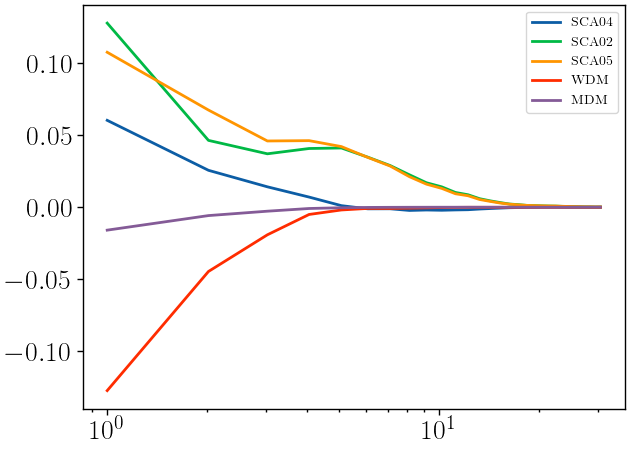

In [21]:
pos_0_ps, r = power_spectrum_1d(position_exposures[0])
pos_1_ps, _ = power_spectrum_1d(position_exposures[1])
pos_2_ps, _ = power_spectrum_1d(position_exposures[2])
pos_3_ps, _ = power_spectrum_1d(position_exposures[3])

plt.plot(r, pos_0_ps - pos_1_ps, label='SCA04')
plt.plot(r, pos_0_ps - pos_2_ps, label='SCA02')
plt.plot(r, pos_0_ps - pos_3_ps, label='SCA05')
plt.plot(r, cdm_ps - wdm_ps, label='WDM')
plt.plot(r, cdm_ps - mdm_ps, label='MDM')
plt.xscale('log')
plt.legend()
plt.show()